# Setup

In [7]:
# import your standard packages
%run ../../global-tools/start.py

# import your local functions
sys.path.insert(1, '../')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Paths and Read Data

In [8]:
infn = '../data/woa_processed.nc'
outfn = '../data/woa_cp.nc'

ds = xr.open_dataset(infn)
ds

<xarray.Dataset>
Dimensions:                      (coastal_loc: 1925, depth: 57, lat: 35, lon: 55, lonmin,lonmax,latmin,latmax: 4, month: 12)
Coordinates:
  * month                        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth                        (depth) float32 0.0 5.0 10.0 ... 1450.0 1500.0
  * lon                          (lon) float32 48.5 49.5 50.5 ... 101.5 102.5
  * lat                          (lat) float32 -1.5 -0.5 0.5 ... 30.5 31.5 32.5
  * coastal_loc                  (coastal_loc) int64 0 1 2 3 ... 1922 1923 1924
  * lonmin,lonmax,latmin,latmax  (lonmin,lonmax,latmin,latmax) int64 0 1 2 3
Data variables:
    temp                         (month, depth, lat, lon) float64 ...
    psal                         (month, depth, lat, lon) float64 ...
    doxy                         (month, depth, lat, lon) float64 ...
    nitrate                      (month, depth, lat, lon) float64 ...
    phosphate                    (month, depth, lat, lon) float64 ...
    pres  

In [9]:
ds.depth

<xarray.DataArray 'depth' (depth: 57)>
array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,   45.,
         50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,   90.,   95.,
        100.,  125.,  150.,  175.,  200.,  225.,  250.,  275.,  300.,  325.,
        350.,  375.,  400.,  425.,  450.,  475.,  500.,  550.,  600.,  650.,
        700.,  750.,  800.,  850.,  900.,  950., 1000., 1050., 1100., 1150.,
       1200., 1250., 1300., 1350., 1400., 1450., 1500.], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
Attributes:
    standard_name:  depth
    bounds:         depth_bnds
    positive:       down
    units:          meters
    axis:           Z

# Find TCP and OCP with Threshold and Gradient Methods

In [3]:
n = len(ds.month)
m = len(ds.lat)
p = len(ds.lon)

TCP_grad = np.full((n,m,p),np.nan)
OCP_grad = np.full((n,m,p),np.nan)

TCP_thresh_20 = np.full((n,m,p),np.nan)
OCP_thresh_50 = np.full((n,m,p),np.nan)

TCP_thresh_23 = np.full((n,m,p),np.nan)
OCP_thresh_100 = np.full((n,m,p),np.nan)

TCP_thresh_25 = np.full((n,m,p),np.nan)
OCP_thresh_150 = np.full((n,m,p),np.nan)

with tqdm(total=n * m * p) as pbar:
    for tt,ii,jj in itertools.product(np.arange(n),np.arange(m),np.arange(p)):
        
        temp = np.array(ds.temp[tt,:,ii,jj])
        doxy = np.array(ds.doxy[tt,:,ii,jj])
        pres = np.array(ds.pres[:,ii,jj])

        # gradient method -----------------------------------------#

        # only take upper 10-500dbar of data
        ind = (pres>=10) & (pres<=500)
        upper_temp = temp[ind]
        upper_doxy = doxy[ind]
        upper_pres = pres[ind]

        # find gradients, min/max gradient inds, and pressure at min inds
        if np.nansum(~np.isnan(upper_temp)) >= 10: 
            temp_grad = np.gradient(upper_temp,upper_pres)
            # note that nanargmin automatically takes the value closest to the surface
            temp_grad_max_ind = np.nanargmax(np.abs(temp_grad))
            TCP_grad[tt,ii,jj] = upper_pres[temp_grad_max_ind]
            
        if np.nansum(~np.isnan(upper_doxy)) >= 10: 
            doxy_grad = np.gradient(upper_doxy,upper_pres)
            doxy_grad_max_ind = np.nanargmax(np.abs(doxy_grad))
            OCP_grad[tt,ii,jj] = upper_pres[doxy_grad_max_ind]

        # threshold method -----------------------------------------#
        doxy_thresh = 100
        temp_thresh = 23
        
        temp_ind = temp <= temp_thresh
        if len(pres[temp_ind]) > 0: 
            TCP_thresh_23[tt,ii,jj] = pres[temp_ind][0]
            
        doxy_ind = doxy <= doxy_thresh
        if len(pres[doxy_ind]) > 0: 
            OCP_thresh_100[tt,ii,jj] = pres[doxy_ind][0]
        
        doxy_thresh = 50
        temp_thresh = 20
        
        temp_ind = temp <= temp_thresh
        if len(pres[temp_ind]) > 0: 
            TCP_thresh_20[tt,ii,jj] = pres[temp_ind][0]
            
        doxy_ind = doxy <= doxy_thresh
        if len(pres[doxy_ind]) > 0: 
            OCP_thresh_50[tt,ii,jj] = pres[doxy_ind][0]
        
        doxy_thresh = 150
        temp_thresh = 25
        
        temp_ind = temp <= temp_thresh
        if len(pres[temp_ind]) > 0: 
            TCP_thresh_25[tt,ii,jj] = pres[temp_ind][0]
            
        doxy_ind = doxy <= doxy_thresh
        if len(pres[doxy_ind]) > 0: 
            OCP_thresh_150[tt,ii,jj] = pres[doxy_ind][0]
    
        pbar.update(1)
    

  0%|          | 31/23100 [00:00<01:15, 303.94it/s]/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in less_equal
100%|██████████| 23100/23100 [01:14<00:00, 308.69it/s]


Text(0.5, 0.98, 'Doxy')

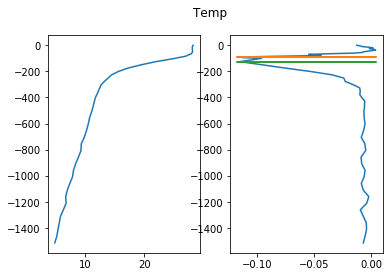

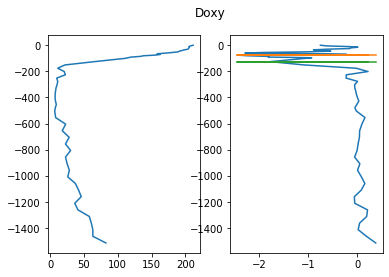

In [4]:
 # Example plot

tt,ii,jj = 1,15,25
temp = np.array(ds.temp[tt,:,ii,jj])
doxy = np.array(ds.doxy[tt,:,ii,jj])
psal = np.array(ds.psal[tt,:,ii,jj])
pres = np.array(ds.pres[:,ii,jj])
# pres = np.array(ds_WOA.pres)
temp_grad = np.gradient(temp,pres)
doxy_grad = np.gradient(doxy,pres)
psal_grad = np.gradient(psal,pres)

upper_temp = temp[pres<=500]
upper_psal = temp[psal<=500]
upper_pres = pres[pres<=500]

f, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(temp,-1*pres)
ax2.plot(temp_grad,-1*pres)
ax2.plot(temp_grad,-1*np.full(pres.shape,TCP_grad[tt,ii,jj]))
ax2.plot(temp_grad,-1*np.full(pres.shape,TCP_thresh_23[tt,ii,jj]))
plt.suptitle('Temp')

f, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(doxy,-1*pres)
ax2.plot(doxy_grad,-1*pres)
ax2.plot(doxy_grad,-1*np.full(pres.shape,OCP_grad[tt,ii,jj]))
ax2.plot(doxy_grad,-1*np.full(pres.shape,OCP_thresh_100[tt,ii,jj]))
plt.suptitle('Doxy')


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


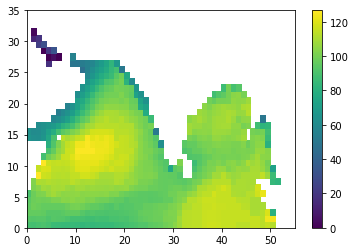

In [5]:
plt.pcolormesh(np.nanmean(TCP_thresh_23,axis=0))
plt.colorbar()

In [6]:
# convert to xarray dataset
ds_out = xr.Dataset(coords={'lon': ds.lon,
                    'lat': ds.lat,
                    'month': ds.month})

coords = [ds.month,ds.lat,ds.lon]
dims = ['month','lat', 'lon']

# add variables to dataset

ds_out["tcp"]=xr.DataArray(TCP_grad,dims = dims,coords = coords)
ds_out["ocp"]=xr.DataArray(OCP_grad,dims = dims,coords = coords)

ds_out["tcp_thresh_20"]=xr.DataArray(TCP_thresh_20,dims = dims,coords = coords)
ds_out["ocp_thresh_50"]=xr.DataArray(OCP_thresh_50,dims = dims,coords = coords)

ds_out["tcp_thresh_23"]=xr.DataArray(TCP_thresh_23,dims = dims,coords = coords)
ds_out["ocp_thresh_100"]=xr.DataArray(OCP_thresh_100,dims = dims,coords = coords)

ds_out["tcp_thresh_25"]=xr.DataArray(TCP_thresh_25,dims = dims,coords = coords)
ds_out["ocp_thresh_150"]=xr.DataArray(OCP_thresh_150,dims = dims,coords = coords)

ds_out["coastal_mask"] = ds.coastal_mask
ds_out["coastal_mask_xx"] = ds.coastal_mask_xx
ds_out["coastal_mask_yy"] = ds.coastal_mask_yy
ds_out['coastal_mask_bounds'] = ds.coastal_mask_bounds

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds_out

<xarray.Dataset>
Dimensions:                      (coastal_loc: 1925, lat: 35, lon: 55, lonmin,lonmax,latmin,latmax: 4, month: 12)
Coordinates:
  * lon                          (lon) float32 48.5 49.5 50.5 ... 101.5 102.5
  * lat                          (lat) float32 -1.5 -0.5 0.5 ... 30.5 31.5 32.5
  * month                        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * coastal_loc                  (coastal_loc) int64 0 1 2 3 ... 1922 1923 1924
  * lonmin,lonmax,latmin,latmax  (lonmin,lonmax,latmin,latmax) int64 0 1 2 3
Data variables:
    tcp                          (month, lat, lon) float64 100.6 85.52 ... nan
    ocp                          (month, lat, lon) float64 65.39 65.39 ... nan
    tcp_thresh_20                (month, lat, lon) float64 125.8 125.8 ... nan
    ocp_thresh_50                (month, lat, lon) float64 nan nan ... nan nan
    tcp_thresh_23                (month, lat, lon) float64 90.55 85.52 ... nan
    ocp_thresh_100               (month, lat, lon) float